In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [4]:
import pickle
with open('../data/processed_oil_gas_data.pickle', 'rb') as f:
    processed_data = pickle.load(f)

X_train = processed_data['X_train']
X_val = processed_data['X_val']
X_test = processed_data['X_test']
y_train = processed_data['y_train']
y_val = processed_data['y_val']
y_test = processed_data['y_test']
feature_names = processed_data['feature_names']
preprocessor = processed_data['preprocessor']

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (541998, 744)
Validation set shape: (6389, 744)
Test set shape: (8114, 744)


In [5]:
def evaluate_model(model, X, y, model_name="Model"):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'predictions': y_pred}

In [13]:
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def objective_rf(trial):
    param = {
        'n_estimators': 10,
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [False]),
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestRegressor(**param)
    model.fit(X_train, y_train)
    results = evaluate_model(model, X_val, y_val)
    return results['rmse']

# Create a study object and optimize
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials = 5)

[I 2025-03-10 19:16:03,041] A new study created in memory with name: no-name-5a0b227d-242a-4877-9b1e-bd503014af73
[I 2025-03-10 19:16:38,018] Trial 0 finished with value: 1.2845169430084773 and parameters: {'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 1.2845169430084773.
[I 2025-03-10 19:16:40,257] Trial 1 finished with value: 2.1589186011169734 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 1.2845169430084773.
[I 2025-03-10 19:17:14,205] Trial 2 finished with value: 1.284516943008478 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 1.2845169430084773.
[I 2025-03-10 19:17:16,750] Trial 3 finished with value: 2.0535594028606 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_l

In [14]:
# Print the best parameters and results
print("Best Random Forest Parameters:", study_rf.best_params)
print("Best Random Forest RMSE:", study_rf.best_value)

Best Random Forest Parameters: {'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': False}
Best Random Forest RMSE: 0.9383770085645543


In [15]:
# Train the model with the best parameters
best_rf = RandomForestRegressor(**study_rf.best_params, random_state=42)
best_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=8, max_features=None,
                      min_samples_leaf=5, min_samples_split=9, random_state=42)

In [16]:
# Evaluate on validation set
rf_val_results = evaluate_model(best_rf, X_val, y_val, "Random Forest (Optimized)")
print(f"Random Forest Optimized Performance:")
print(f"RMSE: {rf_val_results['rmse']:.4f}")
print(f"MAE: {rf_val_results['mae']:.4f}")
print(f"R²: {rf_val_results['r2']:.4f}")

Random Forest Optimized Performance:
RMSE: 0.9384
MAE: 0.8218
R²: -0.0048


/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_17387/848926887.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_rf)


<Figure size 1200x500 with 0 Axes>

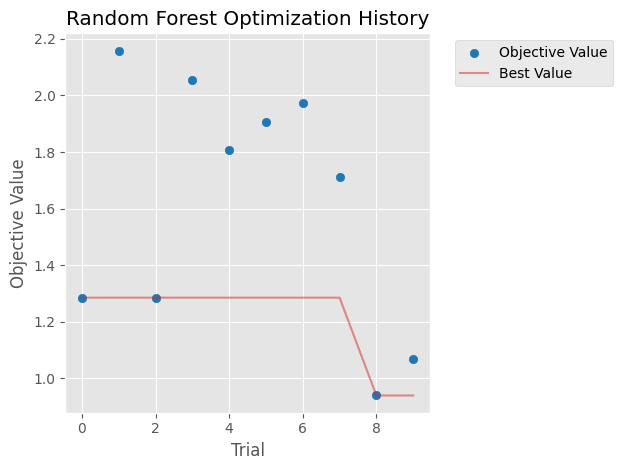

In [21]:
plt.figure(figsize=(12, 5))
optuna.visualization.matplotlib.plot_optimization_history(study_rf)
plt.title('Random Forest Optimization History')
plt.tight_layout()
plt.show()

/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_17387/639706091.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study_rf)


<Figure size 1200x500 with 0 Axes>

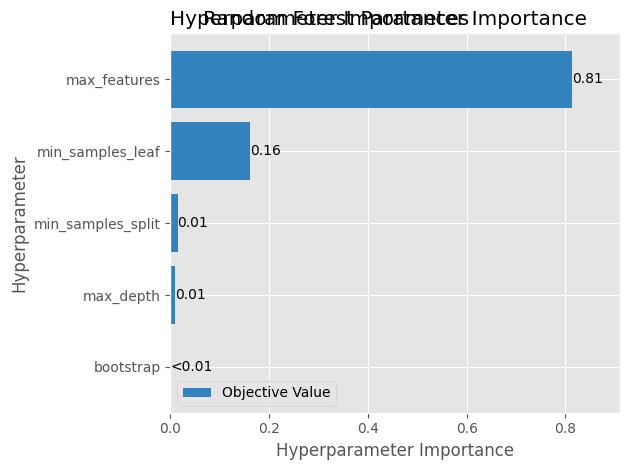

In [22]:
plt.figure(figsize=(12, 5))
optuna.visualization.matplotlib.plot_param_importances(study_rf)
plt.title('Random Forest Parameter Importance')
plt.tight_layout()
plt.show()



In [19]:
import pickle
import os

os.makedirs('models', exist_ok=True)
with open('../models/optuna_study.pkl', 'wb') as f:
    pickle.dump(study_rf, f)
with open('../models/best_params.pkl', 'wb') as f:
    pickle.dump(study_rf.best_params, f)
with open('../models/best_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
